# BasicUsage: Training a Simple Classifier on the FashionMNIST Dataset

- Example consists of training a simple pytorch module using `FitLoop`.
- Demonstrates the most basic usage of `FitLoop`.
- Most things run out of the box for basic usage.

*Imports are called when required.*

## Data

### Obtaining
Getting the data and converting it into dataloaders

In [1]:
import numpy as np
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST

In [2]:
"""
The returned values are torch `Dataset`s.
"""
train_ds_all = FashionMNIST("data",train=True, transform=ToTensor(), download=True)
test_ds = FashionMNIST("data",train=False, transform=ToTensor(), download=True)

labels = np.unique(train_ds_all.targets)
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
class_num = len(class_names)

- Creating `Subset`s from `train_ds_all`
- Using 3000 samples for validation, 0.05 of training data

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [4]:
"""
Generating shuffled and stratified indices for 
splitting `train_ds_all` into a train and test dataset.
"""
idx = np.arange(len(train_ds_all))
targets = train_ds_all.targets   
train_idx, valid_idx = train_test_split(idx, train_size=0.95, stratify=targets)

"""
Subsets of train_ds_all form the generated indices.
"""
train_ds = Subset(train_ds_all, train_idx)
valid_ds = Subset(train_ds_all, valid_idx)

print(f"len :: train_ds:{len(train_ds)} valid_ds:{len(valid_ds)} test_ds:{len(test_ds)}")
print(f"data shape :: {train_ds[0][0].shape}")

len :: train_ds:57000 valid_ds:3000 test_ds:10000
data shape :: torch.Size([1, 28, 28])


Creating `DataLoader`s for trianing, validation and testing `Dataset`s

In [5]:
from torch.utils.data import DataLoader

In [6]:
batch_size = 16

train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

print(f"batches :: train_dl:{len(train_dl)} valid_dl:{len(valid_dl)} test_dl:{len(test_dl)}")

batches :: train_dl:3563 valid_dl:188 test_dl:625


### Visualizing

In [7]:
import matplotlib.pyplot as plt

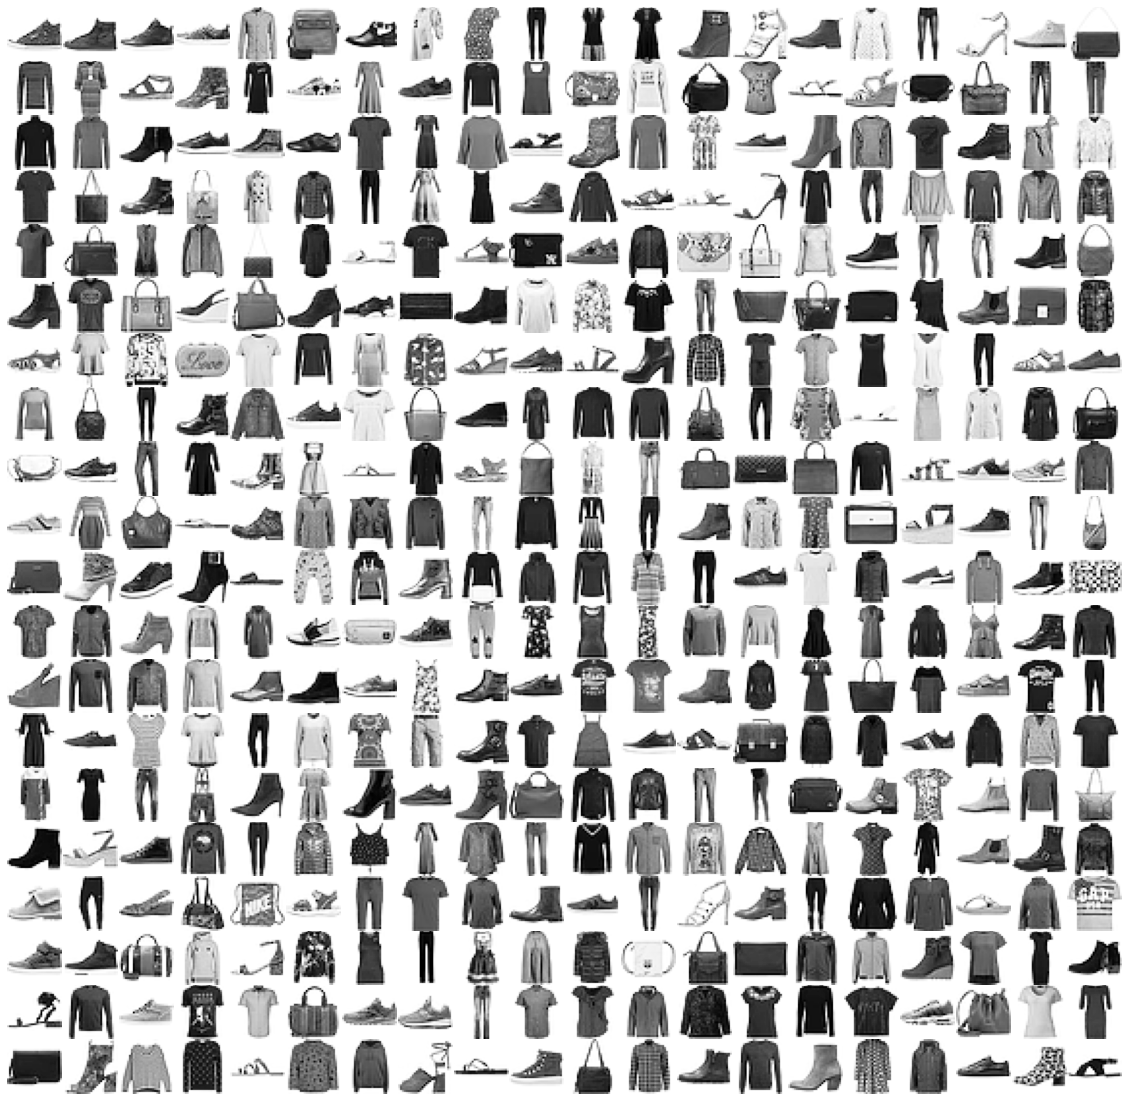

In [8]:
r = 20
c = 20

# Transform to convert to displayable format.
tr = lambda x: x.numpy().reshape(28,28)

# Indices to select random samples from train_ds
idx = np.random.permutation(np.arange(len(train_ds)))[:r*c]

# Plot the images
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(r*c):
    img = tr(train_ds[i][0])
    plt.subplot(r,c,i+1,)
    plt.imshow(img, cmap="Greys")
    plt.axis('off')

## CNN Initialization

Creating a simple CNN using `Sequential`

In [9]:
import torch.nn as nn

Model definition

In [10]:
out_features = len(labels)
model = nn.Sequential(
    nn.Conv2d(1,16,3),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(16,32,3),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Dropout(0.4),
    nn.Linear(800,256),
    nn.ReLU(),
    nn.Linear(256,out_features)
)

## Training

In [11]:
from fitloop import FitLoop

### Initialization

**configure_optimizer**
```python
configure_optimizer(floop:FitLoop) -> None
```
- This function is required so that when the model is reset
  to it's last best state during training the optimizer parameter groups can be reset.
- If this function isn't set, `FitLoop.optimizer` parameter groups will have to be set
  manually, else the weights won't update on further training.
- Model weights are reset:
    - After training if `load_best` arg is `True` in the `FitLoop.fit` function.
    - When `FitLoop.reset` is called.
    - When `FitLoop.run_sanity_check` or `FitLoop.run_profiler` are called.

In [12]:
def configure_optimizer(floop):
    floop.optimizer.param_groups.clear()
    floop.optimizer.add_param_group({
        'params':floop.model.parameters()
    })

Initializing to get a `FitLoop` trainer

In [13]:
from torch.optim import Adam

In [14]:
params = model.parameters()

fdict = {
    "model":model,
    "loss_function":nn.CrossEntropyLoss(),
    "optimizer":Adam(params),
    "train_dl":train_dl,
    "valid_dl":valid_dl,
    "test_dl":test_dl,
    "configure_optimizer":configure_optimizer
}

trainer = FitLoop(**fdict)

### Fit
- Running the fit loop.

In [15]:
trainer.fit(epochs=10)

 [1/10] - train :: accuracy: 0.8071 | loss: 0.5174 
          valid :: accuracy: 0.8757 | loss: 0.3391 
          epoch time: 34 s 222 ms


 [2/10] - train :: accuracy: 0.8647 | loss: 0.3613 
          valid :: accuracy: 0.8940 | loss: 0.2918 
          epoch time: 34 s 864 ms


 [3/10] - train :: accuracy: 0.8810 | loss: 0.3166 
          valid :: accuracy: 0.8937 | loss: 0.2802 
          epoch time: 33 s 975 ms


 [4/10] - train :: accuracy: 0.8905 | loss: 0.2942 
          valid :: accuracy: 0.9013 | loss: 0.2589 
          epoch time: 35 s 101 ms


 [5/10] - train :: accuracy: 0.8969 | loss: 0.2744 
          valid :: accuracy: 0.9103 | loss: 0.2475 
          epoch time: 32 s 775 ms


 [6/10] - train :: accuracy: 0.9002 | loss: 0.2592 
          valid :: accuracy: 0.9100 | loss: 0.2457 
          epoch time: 35 s 217 ms


 [7/10] - train :: accuracy: 0.9068 | loss: 0.2481 
          valid :: accuracy: 0.9157 | loss: 0.2394 
          epoch time: 30 s 781 ms


 [8/10] - train :: accuracy: 0.9103 | loss: 0.2371 
          valid :: accuracy: 0.9180 | loss: 0.2375 
          epoch time: 35 s 434 ms


 [9/10] - train :: accuracy: 0.9125 | loss: 0.2312 
          valid :: accuracy: 0.9177 | loss: 0.2356 
          epoch time: 36 s 141 ms


[10/10] - train :: accuracy: 0.9176 | loss: 0.2204 
          valid :: accuracy: 0.9167 | loss: 0.2332 
          epoch time: 31 s 404 ms

-------
total time: 05 m 39 s 989 ms
best score: 0.9180


### Checking Loss and Accuracy curves

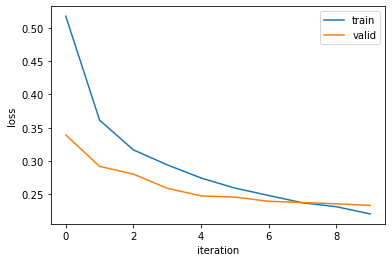

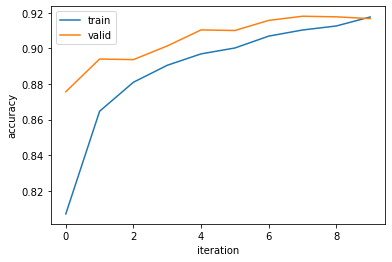

In [16]:
trainer.plot('loss')
trainer.plot('accuracy')

### Testing
Checking accuracy and loss using the passed test data.

In [17]:
trainer.test()

test :: accuracy: 0.9072 | loss: 0.2508 

-----
total time: 02 s 374 ms
